<a href="https://colab.research.google.com/github/jamesgolden1/llms-are-llms/blob/main/llama_3_2_3B_locally_linear_float64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# %%capture
# !pip install transformers==4.52.3 --force-reinstall

In [3]:
#@title Jacobian Analyzer float64
%%writefile /content/llms-are-llms/src/JacobianAnalyzer.py
-*- coding: utf-8 -*-
import os
import gc
import re
import sys
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from collections import defaultdict
from sklearn.utils.extmath import randomized_svd
import importlib

from transformers.utils.import_utils import clear_import_cache

import warnings
warnings.filterwarnings("ignore", message="Glyph .* missing from current font\.")

from . import JacobianSingularVectorPowerIteration

class JacobianAnalyzer:
    """
    A class for analyzing the Jacobian of language models to understand their behavior.

    This class provides methods to compute and analyze the Jacobian matrix of a language
    model's output with respect to its input embeddings. It includes SVD analysis,
    visualization methods, and token interpretation features.
    """

    def __init__(self, model_name="meta-llama/Llama-3.1-8B-Instruct", device="cuda", dtype=torch.float64, load_model=True):
        """
        Initialize the JacobianAnalyzer with a specified model.

        Args:
            model_name (str): HuggingFace model identifier
            device (str): Device to run the model on ('cuda' or 'cpu')
            dtype (torch.dtype): Data type for model computations (e.g., torch.float64 for maximum precision)
        """
        self.device = device
        self.model_name = model_name
        self.last_input_text = None

        # Initialize tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.copy_locally_linear_files()

        # Load and prepare model
        if load_model:
            self.load_model(dtype=dtype)

        # Initialize storage containers for analysis results
        self._init_storage()

    def copy_locally_linear_files(self):
        """
        Copy the modeling_* files with locally linear models in eval mode(and original models in train mode) into the transformers library.

        """
        import shutil
        import transformers
        transformers_file = transformers.__file__.split('__')[0]

        # Llama 3.1
        modeling_file_new = "models/llama_3/modeling_llama_locally_linear.py"
        modeling_file = transformers_file+"models/llama/modeling_llama.py"
        backup_file = transformers_file+"models/llama/modeling_llama_original.py"
        shutil.copy(modeling_file, backup_file)
        shutil.copy(modeling_file_new, modeling_file)
        # clear_import_cache()
        # if 'transformers.models.llama.modeling_llama' in sys.modules:
        # importlib.reload(sys.modules['transformers.models.llama.modeling_llama'])

        # Gemma 3
        modeling_file_new = "models/gemma_3/modeling_gemma_locally_linear.py"
        modeling_file = transformers_file+"models/gemma3/modeling_gemma3.py"
        backup_file = transformers_file+"models/gemma3/modeling_gemma3_original.py"
        shutil.copy(modeling_file, backup_file)
        shutil.copy(modeling_file_new, modeling_file)

        # Qwen 3
        modeling_file_new = "models/qwen_3/modeling_qwen_locally_linear.py"
        modeling_file = transformers_file+"models/qwen3/modeling_qwen3.py"
        backup_file = transformers_file+"models/qwen3/modeling_qwen3_original.py"
        shutil.copy(modeling_file, backup_file)
        shutil.copy(modeling_file_new, modeling_file)

        # Phi 4 # Runs on phi 3 architecture
        modeling_file_new = "models/phi_4/modeling_phi_locally_linear.py"
        modeling_file = transformers_file+"models/phi3/modeling_phi3.py"
        backup_file = transformers_file+"models/phi3/modeling_phi3_original"
        shutil.copy(modeling_file, backup_file)
        shutil.copy(modeling_file_new, modeling_file)

        # Olmo 2
        modeling_file_new = "models/olmo_2/modeling_olmo_locally_linear.py"
        modeling_file = transformers_file+"models/olmo2/modeling_olmo2.py"
        backup_file = transformers_file+"models/olmo2/modeling_olmo2_original.py"
        shutil.copy(modeling_file, backup_file)
        shutil.copy(modeling_file_new, modeling_file)

        # Mistral Ministral
        modeling_file_new = "models/mistral_ministral/modeling_mistral_ministral_locally_linear.py"
        modeling_file = transformers_file+"models/mistral/modeling_mistral.py"
        backup_file = transformers_file+"models/mistral/modeling_mistral_original.py"
        shutil.copy(modeling_file, backup_file)
        shutil.copy(modeling_file_new, modeling_file)

    def _init_storage(self):
        """Initialize all data storage containers."""
        # Jacobian output containers
        self.linear_jacobian_output = None
        self.nonlinear_jacobian_output = None
        self.linear_jacobian_output_error = None
        self.nonlinear_jacobian_output_error = None

        # Model outputs and embeddings
        self.outputs = None
        self.embeds = None
        self.embeds_predicted = None
        self.inputs = None
        self.jacobian = None
        self.jacobian_by_token = None

        # Analysis results containers
        self.sarr = None
        self.uarr = None
        self.varr = None
        self.usvec = None
        self.vsvec = None
        self.usigns = []

        # Column norm analysis containers
        self.scol_arr = None
        self.ucol_arr = None
        self.vrow_arr = None
        self.ucol = []
        self.vrow = []

        # Layer-wise analysis containers (using defaultdict for more robust initialization)
        self.jacobian_layers = defaultdict(list)
        self.jacobian_layers_to_end = defaultdict(list)
        self.uarr_layers = defaultdict(list)
        self.varr_layers = defaultdict(list)
        self.sarr_layers = defaultdict(list)
        self.usvec_layers = defaultdict(list)
        self.usvec_layers_to_output = defaultdict(list)
        self.vsvec_layers = defaultdict(list)
        self.vsvec_layers_to_output = defaultdict(list)
        self.jac_layers = defaultdict(list)
        self.usigns_layers = defaultdict(list)
        self.usigns_layers_to_output = defaultdict(list)

        # Layer-wise detached analysis containers
        self.jacobian_layers_layerwise = defaultdict(list)
        self.uarr_layers_layerwise = defaultdict(list)
        self.varr_layers_layerwise = defaultdict(list)
        self.sarr_layers_layerwise = defaultdict(list)
        self.usvec_layers_layerwise = defaultdict(list)
        self.usvec_layers_layerwise_to_output = defaultdict(list)
        self.vsvec_layers_layerwise = defaultdict(list)
        self.vsvec_layers_layerwise_to_output = defaultdict(list)
        self.jac_layers_layerwise = defaultdict(list)
        self.usigns_layers_layerwise = defaultdict(list)
        self.usigns_layers_layerwise_to_output = defaultdict(list)

        # Layer list for tracking
        self.layerlist = None

    def load_model(self, dtype=torch.bfloat16): # Keep dtype as an argument
        """Load and prepare the model for inference and gradient computation."""

        if "bnb" in self.model_name and "gemma" not in self.model_name:
            self.quantization_config = BitsAndBytesConfig(load_in_4bit=True)
            self.model = AutoModelForCausalLM.from_pretrained(
                self.model_name,
                token=os.environ["HF_TOKEN"],
                quantization_config=self.quantization_config
            )
        else:
            self.model = AutoModelForCausalLM.from_pretrained(
                self.model_name,
                torch_dtype=dtype # Use the specified dtype here
            )
            self.model.to(self.device)

        # Handle model-specific adjustments
        if "gemma" in self.model_name:
            self.model_mm = self.model
            self.model = self.model_mm.language_model
            if callable(getattr(self.model_mm, 'generate')):
                self.model.generate = self.model_mm.generate

    def prepare_input(self, text):
        """
        Prepare input for model processing.

        Args:
            text (str): Input text prompt

        Returns:
            dict: Tokenized inputs moved to the appropriate device
        """
        self.last_input_text = text
        inputs = self.tokenizer([text], padding=True, return_tensors="pt")
        self.inputs = {k: v.to(self.device) for k, v in inputs.items() if k != 'token_type_ids'}
        return self.inputs

    def generate(self, text, max_new_tokens=1, temperature=0.0000001):
        """
        Generate output and extract hidden states.

        Args:
            text (str): Input text prompt
            max_new_tokens (int): Number of tokens to generate
            temperature (float): Sampling temperature (near-zero for deterministic output)

        Returns:
            Model outputs with hidden states
        """
        # Prepare input
        self.prepare_input(text)

        # Set model to evaluation mode
        self.model.eval()

        if hasattr(self, 'model_mm'):
            # Generate outputs with hidden states
            self.outputs = self.model_mm.generate(
                **self.inputs,
                max_new_tokens=max_new_tokens,
                return_dict_in_generate=True,
                output_scores=True,
                past_key_values=None,
                use_cache=False,
                output_hidden_states=True,
                temperature=temperature
            )
        else:
            # Generate outputs with hidden states
            self.outputs = self.model.generate(
                **self.inputs,
                max_new_tokens=max_new_tokens,
                return_dict_in_generate=True,
                output_scores=True,
                past_key_values=None,
                use_cache=True,
                output_hidden_states=True,
                temperature=temperature
            )

        self.output_token = self.tokenizer.decode(self.outputs['sequences'][-1][-1]).strip()
        # print("[", [self.tokenizer.decode(self.outputs['sequences'][ii]) for ii in range(len(self.outputs['sequences']))], "]")

        # Store the embedding for jacobian calculation, explicitly cast to self.model.dtype
        self.embeds = self.outputs.hidden_states[0][0].detach().to(self.model.dtype).requires_grad_(True)
        self.embeds_predicted = self.outputs.hidden_states[-1][-1][0, -1].to(self.model.dtype)


    def model_forward(self, embeds, lstart=0, lsplit=None, key='layer', transform_to_output=False):
        """
        Llama 3 forward pass through model layers with linearization for Jacobian analysis.
        Other model_forward functions from the models folder must be loaded for non-Llama 3 models.

        Args:
            embeds: Input embeddings tensor of shape (batch_size, seq_length, hidden_size)
            lstart (int): Starting layer index
            lsplit (int): Number of layers to process (if None, process all layers)
            key (str): Return type - 'layer' for final layer output, 'attn' for attention output,
                      'mlp' for MLP output, or various input keys

        Returns:
            Hidden states tensor after processing specified layers
        """
        outdict = {}

        if lsplit is None:
            lsplit = len(self.model.model.layers)

        # Get batch size and sequence length
        batch_size, seq_length = embeds.shape[:2]

        # Create position IDs, ensure they are on the correct device and dtype if needed
        position_ids = torch.arange(seq_length, device=embeds.device).unsqueeze(0).expand(batch_size, -1)

        # Generate position embeddings for rotary attention
        # Ensure rotary_emb output matches the desired dtype
        cos, sin = self.model.model.rotary_emb(embeds.to(self.model.dtype), position_ids)
        position_embeddings = (cos.to(self.model.dtype), sin.to(self.model.dtype))

        # Create cache position for tracking position in sequence
        cache_position = torch.arange(seq_length, device=embeds.device)

        # Create basic attention mask (all ones), ensure it's on the correct dtype
        attention_mask = torch.ones(batch_size, seq_length, dtype=self.model.dtype, device=embeds.device)

        # Generate causal mask
        causal_mask = self.model.model._update_causal_mask(
            attention_mask,
            embeds,
            cache_position,
            None,  # past_key_values
            False  # output_attentions
        )

        # Process through layers
        hidden_states = embeds

        for li in range(lstart, lsplit):
            # Store input states if requested
            if key == 'layer_input':
                outdict['layer_input'] = hidden_states
            elif key == 'attn_input':
                outdict['attn_input'] = hidden_states

            # Store residual for skip connection
            residual = hidden_states

            # Apply input layer normalization
            hidden_states = self.model.model.layers[li].input_layernorm(hidden_states)

            # Self Attention
            attn_output, _ = self.model.model.layers[li].self_attn(
                hidden_states=hidden_states,
                attention_mask=causal_mask,
                position_ids=position_ids,
                past_key_value=None,
                output_attentions=False,
                use_cache=False,
                cache_position=cache_position,
                position_embeddings=position_embeddings
            )
            # Ensure attn_output is of the correct dtype
            attn_output = attn_output.to(self.model.dtype)

            # Save attention output if requested
            if key == 'attn':
                if li == lsplit - 1:
                    attn_output = self.model.model.norm(attn_output)
                outdict['attn'] = attn_output

            # Add residual connection
            hidden_states = residual + attn_output

            # Save attention output if requested
            if key == 'attn_plus_residual':
                if li == lsplit - 1:
                    attn_output = self.model.model.norm(hidden_states)
                outdict['attn_plus_residual'] = attn_output

            # Store residual for MLP block
            residual = hidden_states

            # Apply post attention layer normalization
            hidden_states = self.model.model.layers[li].post_attention_layernorm(hidden_states)

            if key == 'mlp_input':
                outdict['mlp_input'] = hidden_states

            # Apply MLP
            mlp_output = self.model.model.layers[li].mlp(hidden_states)
            # Ensure mlp_output is of the correct dtype
            mlp_output = mlp_output.to(self.model.dtype)


            # Save MLP output if requested
            if key == 'mlp':
                if li == lsplit - 1:
                    mlp_output = self.model.model.norm(mlp_output)
                outdict['mlp'] = mlp_output

            # Add residual connection
            hidden_states = residual + mlp_output

        # Apply final normalization if we processed all layers
        if key != "layer_input" and li == lsplit - 1 and not transform_to_output:
            hidden_states = self.model.model.norm(hidden_states)

        # Store final layer output
        outdict['layer'] = hidden_states

        # Return the appropriate output based on key
        if key in ["layer_input", "attn_input", "mlp_input"]:
            return outdict[key]
        else:
            return outdict[key][0, -1]

    def compute_jacobian(self):
        """
        Compute Jacobian for the model in evaluation mode.

        Returns:
            Tensor: Linear jacobian output
        """
        # Linear mode (eval)
        self.model.eval().to(torch.float64)

        # Ensure embeds is float64 before passing to jacobian computation
        self.embeds = self.embeds.to(torch.float64)

        self.jacobian = torch.autograd.functional.jacobian(
            self.model_forward,
            self.embeds,
            vectorize=True,
            strategy="reverse-mode"
        ).squeeze()

        # Ensure the Jacobian itself is float64
        self.jacobian = self.jacobian.to(torch.float64)

        # Calculate Jacobian by token
        if len(self.jacobian.shape)==2:
            self.jacobian=self.jacobian.unsqueeze(1)
        self.jacobian_by_token = torch.stack([
            torch.matmul(self.jacobian[:, ii, :].squeeze(), self.embeds[0, ii, :].squeeze())[:]
            for ii in range(self.jacobian.shape[1])
        ])
        # Ensure jacobian_by_token is float64
        self.jacobian_by_token = self.jacobian_by_token.to(torch.float64)

        # Calculate linear Jacobian output and error
        self.linear_jacobian_output = torch.sum(self.jacobian_by_token, dim=0).to(torch.float64)
        self.linear_jacobian_output_error = (self.linear_jacobian_output - self.outputs.hidden_states[-1][-1][0, -1].to(torch.float64))

        # Confirm model_forward exactly matches outputs from generate
        # Ensure comparison is done with float64
        print("model_forward_error:", (self.embeds_predicted - self.model_forward(self.embeds)).to(torch.float64))

        # print("model_forward_error allclose:",torch.allclose(self.embeds_predicted.to(torch.float64),self.model_forward(self.embeds).to(torch.float64)))
        print("detached Jacobian error:", self.linear_jacobian_output_error)
        # print("detached Jacobian all close:",torch.allclose(self.linear_jacobian_output, self.embeds_predicted.to(torch.float64)))

        print(self.linear_jacobian_output - self.model_forward(self.embeds))#.to(torch.float64))
        print(torch.std(self.linear_jacobian_output - self.model_forward(self.embeds)))#.to(torch.float64))
        print(torch.mean((self.linear_jacobian_output - self.model_forward(self.embeds))**2))#.to(torch.float64))
        # plt.figure()

        self.linear_jacobian_output_error = self.linear_jacobian_output - self.model_forward(self.embeds)#.to(torch.float64))

        from torchmetrics.regression import R2Score
        # Initialize the R2Score metric
        r2_metric = R2Score()

        # Update the metric and compute the R2 score
        r2_score = r2_metric(self.linear_jacobian_output, self.model_forward(self.embeds))
        print("R^2: ", r2_score)

        print(f"My value is: {r2_score:.9f}")
        # print(f".9f}")

        from sklearn.metrics import r2_score

        r2_sk = r2_score(self.model_forward(self.embeds).detach().cpu().numpy(),self.linear_jacobian_output.detach().cpu().numpy())
        print(f"{r2_sk:.16f}")
        return self.linear_jacobian_output

    def compute_jacobian_nonlinear(self):
        """
        Compute Jacobian for the model in training mode (nonlinear).

        Returns:
            Tensor: Nonlinear jacobian output
        """
        # Nonlinear mode (train)
        self.model.train()
        jacobian_tr = torch.autograd.functional.jacobian(
            self.model_forward,
            self.embeds,
            vectorize=True,
            strategy="reverse-mode"
        ).squeeze()

        jacobian_by_token = torch.stack([
            torch.matmul(jacobian_tr[:, ii, :], self.embeds[0, ii, :].squeeze())[:]
            for ii in range(jacobian_tr.shape[1])
        ])

        self.nonlinear_jacobian_output = torch.sum(jacobian_by_token, dim=0)
        self.nonlinear_jacobian_output_error = self.nonlinear_jacobian_output - self.outputs.hidden_states[-1][-1][0, -1]

        # Put model back in eval mode
        self.model.eval()

        return self.nonlinear_jacobian_output

    def compute_jacobian_layer_i(self, i=None, key='layer', transform_to_output=False):
        """
        Compute Jacobian for a specific layer.

        Args:
            i (int, optional): Layer index. If None, uses all layers.
            key (str): Type of output to get from the layer.

        Returns:
            Tensor: Jacobian for the specified layer
        """
        if i is None:
            i = len(self.model.model.layers)

        # Linear mode (eval)
        self.model.eval()
        model_forward_lsplit = partial(self.model_forward, lsplit=i, key=key, transform_to_output=transform_to_output)
        print("model_forward_output: ", model_forward_lsplit(self.embeds))
        jacobian_layer_i = torch.autograd.functional.jacobian(
            model_forward_lsplit,
            self.embeds,
            vectorize=True,
            strategy="reverse-mode"
        ).squeeze()

        return jacobian_layer_i

    def compute_jacobian_layerwise_i(self, i=None, key='layer', transform_to_output=False):
        """
        Compute Jacobian for a specific layer considering only that layer's transformation.

        Args:
            i (int, optional): Layer index
            key (str): Type of output to get from the layer

        Returns:
            Tensor: Layer-specific Jacobian
        """
        # Get input to the layer
        x_layer_input = self.model_forward(self.embeds, lsplit=i, key='layer_input')

        # Compute Jacobian for just this layer
        self.model.eval()
        model_forward_lsplit = partial(self.model_forward, lstart=i-1, lsplit=i, key=key, transform_to_output=transform_to_output)
        print("model_forward_output, layerwise: ", model_forward_lsplit(x_layer_input))
        jacobian_layerwise_i = torch.autograd.functional.jacobian(
            model_forward_lsplit,
            x_layer_input,
            vectorize=True,
            strategy="reverse-mode"
        ).squeeze()

        return jacobian_layerwise_i

    def compute_jacobian_layer_i_to_end(self, i=None, transform_to_last_layer=None, key='layer'):
        """
        Compute Jacobian for a specific layer considering only that layer's transformation.

        Args:
            i (int, optional): Layer index
            key (str): Type of output to get from the layer

        Returns:
            Tensor: Layer-specific Jacobian
        """
        # Linear mode (eval)
        self.model.eval()
        if transform_to_last_layer is None:
            transform_to_last_layer=len(self.model.model.layers)-1
        # Get input to the layer
        x_layer_input = self.model_forward(self.embeds, lsplit=i, key='layer_input')
        # model_forward_lsplit = partial(self.model_forward, lstart=i-1, lsplit=i, key=key)
        model_forward_lsplit_end = partial(self.model_forward, lstart=i-1, lsplit=transform_to_last_layer, key=key)
        print("to end, x input: ", x_layer_input[0][-1])
        # print("to end, x input: ", self.model.model.norm(x_layer_input)[0][-1])
        print("to end, output: ",model_forward_lsplit_end(x_layer_input))
        jacobian_layer_i_to_end = torch.autograd.functional.jacobian(
            model_forward_lsplit_end,
            x_layer_input,
            vectorize=True,
            strategy="reverse-mode"
        ).squeeze()

        return jacobian_layer_i_to_end

    def compute_jacobian_svd_fast_layer_i(self, i=None, key='layer', transform_to_output=False, num_singular_vectors=3):
        """
        Compute Jacobian for a specific layer.

        Args:
            i (int, optional): Layer index. If None, uses all layers.
            key (str): Type of output to get from the layer.

        Returns:
            Tensor: Jacobian for the specified layer
        """
        if i is None:
            i = len(self.model.model.layers)

        # Linear mode (eval)
        self.model.eval()

        model_forward_lsplit = partial(self.model_forward, lsplit=i, key=key, transform_to_output=transform_to_output)
        print("model_forward_output: ", model_forward_lsplit(self.embeds))

        jacobian_svd_layer_i = JacobianSingularVectorPowerIteration.jacobian_svd_vectorized(
            model_forward_lsplit,
            self.embeds,
            num_singular_vectors=num_singular_vectors,
            strategy='randomized',
            per_token=True,
            num_iter=6,         # Fewer power iterations for speed (default is 4)
            oversampling=10,     # Less oversampling for speed (default is 10)
            disable_flash_attn=True,
            debug=True
        )

        return jacobian_svd_layer_i

    def compute_jacobian_svd_fast_layerwise_i(self, i=None, key='layer', transform_to_output=False):
        """
        Compute Jacobian for a specific layer.

        Args:
            i (int, optional): Layer index. If None, uses all layers.
            key (str): Type of output to get from the layer.

        Returns:
            Tensor: Jacobian for the specified layer
        """
        if i is None:
            i = len(self.model.model.layers)

        # Linear mode (eval)
        self.model.eval()

        # Get input to the layer
        x_layer_input = self.model_forward(self.embeds, lsplit=i, key='layer_input')

        # Compute Jacobian for just this layer
        model_forward_lsplit = partial(self.model_forward, lstart=i-1, lsplit=i, key=key, transform_to_output=transform_to_output)

        jacobian_svd_layerwise_i = JacobianSingularVectorPowerIteration.jacobian_svd_vectorized(
            model_forward_lsplit,
            x_layer_input,
            num_singular_vectors=4,
            strategy='randomized',
            per_token=True,
            num_iter=6,         # Fewer power iterations for speed (default is 4)
            oversampling=10,#40,     # Less oversampling for speed (default is 10)
            disable_flash_attn=True,
            debug=True
        )

        return jacobian_svd_layerwise_i

    def compute_jacobian_svd_fast_layer_i_to_end(self, i=None, key='layer', transform_to_output=False):
        """
        Compute Jacobian for a specific layer.

        Args:
            i (int, optional): Layer index. If None, uses all layers.
            key (str): Type of output to get from the layer.

        Returns:
            Tensor: Jacobian for the specified layer
        """
        if i is None:
            i = len(self.model.model.layers)

        # Linear mode (eval)
        self.model.eval()

        if transform_to_last_layer is None:
            transform_to_last_layer=len(self.model.model.layers)-1

        # Get input to the layer
        x_layer_input = self.model_forward(self.embeds, lsplit=i, key='layer_input')

        # model_forward_lsplit = partial(self.model_forward, lstart=i-1, lsplit=i, key=key)
        model_forward_lsplit_end = partial(self.model_forward, lstart=i-1, lsplit=transform_to_last_layer, key=key)

        print("to end, x input: ", x_layer_input[0][-1])
        # print("to end, x input: ", self.model.model.norm(x_layer_input)[0][-1])

        print("to end, output: ",model_forward_lsplit_end(x_layer_input))

        jacobian_svd_layer_i_to_end = JacobianSingularVectorPowerIteration.jacobian_svd_vectorized(
            model_forward_lsplit_end,
            x_layer_input,
            num_singular_vectors=4,
            strategy='randomized',
            per_token=True,
            num_iter=6,         # Fewer power iterations for speed (default is 4)
            oversampling=40,     # Less oversampling for speed (default is 10)
            disable_flash_attn=True,
            debug=True
        )

        return jacobian_svd_layer_i_to_end

    def softmax(self, logits):
        return np.exp(logits) / np.sum(exp_logits)

    def find_nearest_token_batched(self, vector, top_k=1, batch_size=1000):
        """
        Find the nearest tokens to a given vector in the embedding space.

        Args:
            vector: The vector to find nearest tokens for
            top_k (int): Number of top tokens to return
            batch_size (int): Batch size for processing

        Returns:
            list: Top k nearest tokens
        """
        # Convert to tensor if not already
        if not isinstance(vector, torch.Tensor):
            vector = torch.tensor(vector, dtype=self.model.lm_head.weight[0].dtype,device=self.model.lm_head.weight[0,0].device)

        # Get embedding matrix and normalize
        embed_matrix = self.model.model.embed_tokens.weight
        embedding_norms = torch.norm(embed_matrix, dim=1, keepdim=True)
        embed_matrix = embed_matrix / embedding_norms
        vocab_size = embed_matrix.shape[0]

        # Move vector to device and normalize
        vector = vector.to(embed_matrix.device)
        vector_norm = torch.norm(vector)
        vector = vector / vector_norm

        # Initialize arrays for top similarities and indices
        max_similarities = torch.full((top_k,), float('-inf'), device=embed_matrix.device)
        max_indices = torch.zeros(top_k, dtype=torch.long, device=embed_matrix.device)

        # Process in batches to avoid memory issues
        for i in range(0, vocab_size, batch_size):
            batch = embed_matrix[i:i+batch_size]
            similarities = torch.matmul(batch, vector)

            # Find top similarities in combined data
            combined = torch.cat([max_similarities, similarities])
            top_combined, top_indices = torch.topk(combined, k=top_k)

            max_similarities = top_combined
            max_indices = torch.where(top_indices < top_k, max_indices, torch.tensor(i, device=embed_matrix.device) + top_indices - top_k)

        # Convert indices to tokens
        vocab = self.tokenizer.get_vocab()
        vocab2 = {v: k for k, v in vocab.items()}
        tokens = [vocab2.get(idx.item(), "") for idx in max_indices]

        return tokens

    def compute_jacobian_svd(self, n_components=128, svs=8, layers=False, layerwise=False,
                            tokens_combined=False, token_list=None, li=None, key='layer', transform_to_output=False, fast_approx=False):
        """
        Compute SVD on the Jacobian matrix and analyze singular vectors.

        Args:
            n_components (int): Number of SVD components to compute
            svs (int): Number of singular vectors to interpret
            layers (bool): Whether to analyze by layers
            layerwise (bool): Whether to analyze each layer separately
            tokens_combined (bool): Whether to combine tokens
            token_list (list): List of token indices to analyze
            li (int): Specific layer index
            key (str): Type of output to analyze

        Returns:
            tuple: SVD analysis results (sarr, uarr, varr, usvec, vsvec)
        """
        # Make sure Jacobian has been computed
        if not hasattr(self, 'linear_jacobian_output'):
            raise ValueError("Jacobian has not been computed. Run compute_jacobian() first.")

        if not fast_approx:
            # Select the appropriate Jacobian based on parameters
            if layers:
                if tokens_combined:
                    jacobian_np = self.jacobian_layers[key][-1].view([self.jacobian_layers[key][-1].shape[0], -1]).cpu().detach().float().numpy()
                else:
                    jacobian_np = self.jacobian_layers[key][-1].cpu().detach().float().numpy()
            elif layerwise:
                if tokens_combined:
                    jacobian_np = self.jacobian_layers_layerwise[key][-1].view([self.jacobian_layers_layerwise[key][-1].shape[0], -1]).cpu().detach().float().numpy()
                else:
                    jacobian_np = self.jacobian_layers_layerwise[key][-1].cpu().detach().float().numpy()
            else:
                if tokens_combined:
                    jacobian_np = self.jacobian.view([self.jacobian.shape[0], -1]).cpu().detach().float().numpy()
                else:
                    jacobian_np = self.jacobian.cpu().detach().float().numpy()

            if len(jacobian_np.shape)==2:
                jacobian_np = np.expand_dims(jacobian_np,axis=1)
            # Determine token range
            sarr, uarr, varr = [], [], []

            if token_list is not None and not tokens_combined and not layers:
                tkend = jacobian_np.shape[1]
                tklist = list(range(tkend))
            elif token_list is not None:
                tklist = token_list
            elif not layers:
                tkend = jacobian_np.shape[1]
                tklist = list(range(tkend))
            else:
                tkend = 1
                tklist = [0]
                # tkend = jacobian_np.shape[1]
                # tklist = list(range(tkend))

            # Compute SVD for each token position
            for tkind in tklist:
                print(f"Computing SVD for token position {tkind}")
                if not tokens_combined:
                    U, Sigma, VT = randomized_svd(
                        jacobian_np[:, tkind, :],
                        n_components=n_components,
                        n_iter='auto',
                        random_state=None
                    )
                    if transform_to_output:
                        print("Transforming to output")
                        jacobian_to_end_np = self.jacobian_layers_to_end[key][-1].cpu().detach().float().numpy()
                        if len(jacobian_to_end_np.shape)==2:
                            jacobian_to_end_np = np.expand_dims(jacobian_to_end_np,axis=1)
                        U = jacobian_to_end_np[:, tkind, :].squeeze()@U
                else:
                    print(jacobian_np.shape)
                    U, Sigma, VT = randomized_svd(
                        jacobian_np[:, :],
                        n_components=n_components,
                        n_iter='auto',
                        random_state=None,
                        flip_sign=False
                    )
                sarr.append(Sigma)
                uarr.append(U)
                varr.append(VT)

        else: # fast_approx, svd already computed

            tkend = self.embeds.shape[1]
            tklist = list(range(tkend))

            if layerwise:
                sarr = self.sarr_layers_layerwise[key][-1]
                uarr = self.uarr_layers_layerwise[key][-1]
                varr = self.varr_layers_layerwise[key][-1]

            else: # layers:
                sarr = self.sarr_layers[key][-1]
                uarr = self.uarr_layers[key][-1]
                varr = self.varr_layers[key][-1]

        # Analyze singular vectors
        self.usvec, self.vsvec = [], []
        for tkind,tkval in enumerate(tklist):
            usvec, vsvec = [], []

            # Compute normalized output projection
            onp = self.linear_jacobian_output.detach().cpu().float().numpy()
            onp /= np.linalg.norm(onp)

            # Normalize singular vectors
            uit = np.array(uarr[tkind])

            # Find sign for singular vectors
            usigns = np.array([np.sign(onp @ (uit[:, ui]) / np.linalg.norm(uit[:, ui]).T) for ui in range(n_components)])

            # Interpret left singular vectors through model's token vocabulary
            s_vector = sarr[tkind]
            for ii in range(svs):
                # Project singular vector through the model's output layer
                u_vector = torch.tensor(uarr[tkind][:, ii], dtype=self.model.lm_head.weight[0].dtype).to(self.device)

                # if layers and len(self.model.model.layers) - 1 != li:
                #     outrecon = -usigns[ii] * self.model.lm_head(self.model.model.norm(u_vector).to(self.model.lm_head.weight[0,0].device))
                # else:
                outrecon = -usigns[ii] * self.model.lm_head(u_vector.to(self.model.lm_head.weight[0,0].device))

                # Get top tokens based on projection
                top_token_indices = torch.argsort(outrecon)[:8]
                # top_token_probs = torch.softmax(-outrecon,dim=0)[top_token_indices]
                decoded_tokens = [self.tokenizer.decode(idx).replace('\n', '') for idx in top_token_indices]
                # decoded_tokens = [f"{top_token_probs[ti]:.3e}"+':'+self.tokenizer.decode(idx).replace('\n', '') for ti,idx in enumerate(top_token_indices)]
                dec_usvec = ' '.join(decoded_tokens)

                print(f"Token {tkval}, U {ii}, mag={s_vector[ii]:.2f}: {dec_usvec}")
                usvec.append(dec_usvec)

                if not tokens_combined:
                    # Find nearest tokens for right singular vectors
                    vvec = usigns[ii] * varr[tkind].T[:, ii]
                    # if self.model.lm_head.weight[0].dtype == torch.float16:
                    #     dec_vsvec = [self.tokenizer.convert_tokens_to_string([token.half()]) for token in self.find_nearest_token_batched(vvec, top_k=8)]
                    # else:
                    dec_vsvec = [self.tokenizer.convert_tokens_to_string([token]) for token in self.find_nearest_token_batched(vvec, top_k=8)]
                    # print(f"Token {tkval}, V SV {ii}: {dec_vsvec}\n")
                    vsvec.append(dec_vsvec)
                else:
                    vsvec.append([""])

            # Store results in appropriate container
            if layers:
                if transform_to_output:
                    self.usvec_layers_to_output[key].append(usvec)
                    self.vsvec_layers_to_output[key].append(vsvec)
                    self.usigns_layers_to_output[key].append(usigns)
                else:
                    self.usvec_layers[key].append(usvec)
                    self.vsvec_layers[key].append(vsvec)
                    self.usigns_layers[key].append(usigns)
            elif layerwise:
                if transform_to_output:
                    self.usvec_layers_layerwise_to_output[key].append(usvec)
                    self.vsvec_layers_layerwise_to_output[key].append(vsvec)
                    self.usigns_layers_layerwise_to_output[key].append(usigns)
                else:
                    self.usvec_layers_layerwise[key].append(usvec)
                    self.vsvec_layers_layerwise[key].append(vsvec)
                    self.usigns_layers_layerwise[key].append(usigns)
            else:
                self.usvec.append(usvec)
                self.vsvec.append(vsvec)
                self.usigns.append(usigns)

        # Store SVD results
        if layers:
            self.sarr_layers[key].append(sarr)
            self.uarr_layers[key].append(uarr)
            self.varr_layers[key].append(varr)
        elif layerwise:
            self.sarr_layers_layerwise[key].append(sarr)
            self.uarr_layers_layerwise[key].append(uarr)
            self.varr_layers_layerwise[key].append(varr)
        else:
            self.sarr = sarr
            self.uarr = uarr
            self.varr = varr

        # return sarr, uarr, varr, usvec, vsvec

    def compute_jacobian_row_col_norm(self, n_components=8, layers=False, tokens_combined=False, li=None):
        """
        Compute the largest columns on the Jacobian matrix and decode vectors.

        Args:
            n_components (int): Number of components to compute
            layers (bool): Whether to analyze by layers
            tokens_combined (bool): Whether to combine tokens
            li (int): Specific layer index

        Returns:
            None: Results stored in instance variables
        """
        import numpy as np

        # Make sure Jacobian has been computed
        if not hasattr(self, 'linear_jacobian_output'):
            raise ValueError("Jacobian has not been computed. Run compute_jacobian() first.")

        # Select appropriate Jacobian
        if layers:
            if tokens_combined:
                jacobian_np = self.jacobian_layers[-1].view([self.jacobian_layers[-1].shape[0], -1]).cpu().detach().float().numpy()
            else:
                jacobian_np = self.jacobian_layers[-1].cpu().detach().float().numpy()
        else:
            if tokens_combined:
                jacobian_np = self.jacobian.view([self.jacobian.shape[0], -1]).cpu().detach().float().numpy()
            else:
                jacobian_np = self.jacobian.cpu().detach().float().numpy()

        # Determine number of tokens to process
        tkend = 1 if tokens_combined else jacobian_np.shape[1]
        ucol, vrow, scol = [], [], []

        # Compute column norms for each token position
        for tkind in range(tkend):
            print(f"Computing col norms for token position {tkind}")
            if not tokens_combined:
                # Compute column norms
                normcol = -np.abs(np.linalg.norm(jacobian_np[:, tkind, :], axis=0))
                Ui = np.argsort(normcol)
                scoli = -np.sort(normcol)

                ucoli = jacobian_np[:, tkind, :][:, Ui[:n_components]]
                vrowi = jacobian_np[:, tkind, :][Ui[:n_components], :]
            else:
                normcol = -np.abs(np.linalg.norm(jacobian_np[:, :], axis=0))
                Ui = np.argsort(normcol)
                scoli = np.sort(normcol)

                normrow = -np.abs(np.linalg.norm(jacobian_np[:, :], axis=1))
                Vi = np.argsort(normrow)

                ucoli = jacobian_np[:, :][:, Ui[:n_components]]
                vrowi = jacobian_np[:, :][Vi[:n_components], :]

            scol.append(scoli)
            ucol.append(ucoli)
            vrow.append(vrowi)

        # Analyze vectors
        self.ucol, self.vrow = [], []
        for tkind in range(tkend):
            ucolvec, vrowvec = [], []

            # Compute normalized output projection
            onp = self.linear_jacobian_output.detach().cpu().float().numpy()
            onp /= np.linalg.norm(onp)

            # Find sign for vectors
            uit = np.array(ucol[tkind])
            usigns = np.array([np.sign(onp @ (uit[:, ui]) / np.linalg.norm(uit[:, ui]).T) for ui in range(n_components)])

            # Find sign for vectors
            vit = np.array(vrow[tkind])
            vsigns = np.array([np.sign(onp.T @ (vit[vi, :]) / np.linalg.norm(vit[vi, :])) for vi in range(n_components)])

            # Interpret vectors through model's token vocabulary
            for ii in range(n_components):
                # Project vector through the model's output layer
                uvec = torch.tensor(ucol[tkind][:, ii], dtype=self.model.lm_head.weight[0].dtype).to(self.device)

                if layers and len(self.model.model.layers) - 1 != li:
                    outrecon = -usigns[ii] * self.model.lm_head(self.model.model.norm(uvec))
                else:
                    outrecon = -usigns[ii] * self.model.lm_head(uvec)

                # Get top tokens based on projection
                top_token_indices = torch.argsort(outrecon)[:8]
                decoded_tokens = [self.tokenizer.decode(idx).replace('\n', '') for idx in top_token_indices]
                dec_uvec = ' '.join(decoded_tokens)

                ucolvec.append(dec_uvec)

                if not tokens_combined:
                    # Find nearest tokens for right vectors
                    vvec = usigns[ii] * vrow[tkind].T[:, ii]
                    dec_vvec = [self.tokenizer.convert_tokens_to_string([token]) for token in self.find_nearest_token_batched(vvec, top_k=4)]
                    vrowvec.append(dec_vvec)
                else:
                    vsvec.append([""])

            # Store results
            if layers:
                self.ucol_layers.append(ucolvec)
                self.vrow_layers.append(vrowvec)
            else:
                self.ucol.append(ucolvec)
                self.vrow.append(vrowvec)

        # Store array results
        self.scol_arr = scol
        self.ucol_arr = ucol
        self.vrow_arr = vrow

    def compute_jacobian_layers_svd(self, layerlist, tokens_combined=True, token_list=None,
                                   n_components=8, svs=1, key='layer', input_key='layer_input',
                                   layer_mode='cumulative', transform_to_output=False, transform_to_last_layer=None, fast_approx=False):
        """
        Compute SVD analysis across multiple layers.

        Args:
            layerlist (list): List of layer indices to analyze
            tokens_combined (bool): Whether to combine tokens
            token_list (list): List of token indices to analyze
            n_components (int): Number of SVD components
            svs (int): Number of singular vectors to interpret
            key (str): Type of output to analyze
            input_key (str): Type of input to use
            layer_mode (str): 'cumulative' or 'layerwise'

        Returns:
            None: Results stored in instance variables
        """
        self.layerlist = layerlist

        if token_list is None:
            token_list = [0]

        if fast_approx: # use power iteration for fast approximation of top singular vectors

            for layeri in layerlist:
                if layer_mode == 'cumulative':
                    print(key, "layer", layeri)
                    jacobian_layer_i_svd = self.compute_jacobian_svd_fast_layer_i(i=layeri, key=key, transform_to_output=transform_to_output)
                    # print(jacobian_layer_i_svd.shape)
                    print(jacobian_layer_i_svd[0].shape)

                    self.uarr_layers[key].append(jacobian_layer_i_svd[0])#.detach().cpu().float().numpy())
                    self.sarr_layers[key].append(jacobian_layer_i_svd[1])#.detach().cpu().float().numpy())
                    self.varr_layers[key].append(jacobian_layer_i_svd[2])#.detach().cpu().float().numpy())

                    # if transform_to_output:
                    #     print("to output...")
                    #     self.jacobian_layers_to_end[key].append(self.compute_jacobian_svd_fast_layer_i_to_end(i=layeri+1, key=key, transform_to_last_layer=transform_to_last_layer))
                    # del jacobian_layer_i_svd
                    # gc.collect()
                    # if torch.cuda.is_available():
                    #     torch.cuda.empty_cache()
                    #     torch.cuda.synchronize()  # Ensure all operations complete

                    self.compute_jacobian_svd(layers=True, n_components=n_components, svs=svs,
                                            tokens_combined=tokens_combined, token_list=token_list,
                                            li=layeri, key=key, transform_to_output=transform_to_output, fast_approx=fast_approx)

                else:
                    print(key, "layer", layeri, "layerwise, fast")

                    jacobian_layerwise_i_svd = self.compute_jacobian_svd_fast_layerwise_i(i=layeri, key=key, transform_to_output=transform_to_output)

                    print(jacobian_layerwise_i_svd[0].shape)

                    self.uarr_layers_layerwise[key].append(jacobian_layerwise_i_svd[0])#.detach().cpu().float().numpy())
                    self.sarr_layers_layerwise[key].append(jacobian_layerwise_i_svd[1])#.detach().cpu().float().numpy())
                    self.varr_layers_layerwise[key].append(jacobian_layerwise_i_svd[2])#.detach().cpu().float().numpy())

                    # del jacobian_layerwise_i_svd
                    # gc.collect()
                    # if torch.cuda.is_available():
                    #     torch.cuda.empty_cache()
                    #     torch.cuda.synchronize()  # Ensure all operations complete

                    # if transform_to_output:
                    #     self.jacobian_layers_to_end[key].append(self.compute_jacobian_layer_i_to_end(i=layeri+1, key=key, transform_to_last_layer=transform_to_last_layer))

                    self.compute_jacobian_svd(layerwise=True, n_components=n_components, svs=svs,
                                            tokens_combined=tokens_combined, token_list=token_list,
                                            li=layeri, key=key, transform_to_output=transform_to_output, fast_approx=fast_approx)
        else: # full jacobian and truncated svd

            for layeri in layerlist:
                if layer_mode == 'cumulative':
                    print(key, "layer", layeri)
                    self.jacobian_layers[key].append(self.compute_jacobian_layer_i(i=layeri, key=key, transform_to_output=transform_to_output).detach().cpu())
                    if transform_to_output:
                        print("to output...")
                        self.jacobian_layers_to_end[key].append(self.compute_jacobian_layer_i_to_end(i=layeri+1, key=key, transform_to_last_layer=transform_to_last_layer).detach().cpu())
                    self.compute_jacobian_svd(layers=True, n_components=n_components, svs=svs,
                                            tokens_combined=tokens_combined, token_list=token_list,
                                            li=layeri, key=key, transform_to_output=transform_to_output)
                else:
                    print(key, "layer", layeri, "layerwise")
                    self.jacobian_layers_layerwise[key].append(self.compute_jacobian_layerwise_i(i=layeri, key=key, transform_to_output=transform_to_output).detach().cpu())
                    if transform_to_output:
                        self.jacobian_layers_to_end[key].append(self.compute_jacobian_layer_i_to_end(i=layeri+1, key=key, transform_to_last_layer=transform_to_last_layer).detach().cpu())
                    self.compute_jacobian_svd(layerwise=True, n_components=n_components, svs=svs,
                                            tokens_combined=tokens_combined, token_list=token_list,
                                            li=layeri, key=key, transform_to_output=transform_to_output)
            gc.collect()
            torch.cuda.empty_cache()

    def plot_jacobian_comparison(self, text=None, filename=None, filename_png=None):
        """
        Plot comparison of linear and nonlinear Jacobian outputs.

        Args:
            text (str): Input text used for generation
            filename (str, optional): Path to save the output figure (.pdf and .svg)
            filename_png (str, optional): Path to save the output figure (.png)

        Returns:
            matplotlib.figure.Figure: The created figure
        """
        # Convert tensors to numpy arrays
        xvalslin = self.outputs.hidden_states[-1][-1][-1][-1].cpu().detach().float().numpy()
        xvalsnon = xvalslin  # Same values for both

        outnplinear = self.linear_jacobian_output_error.cpu().detach().float().numpy()
        outnpnonlinear = self.nonlinear_jacobian_output_error.cpu().detach().float().numpy()

        linear_out_np = self.linear_jacobian_output.cpu().detach().float().numpy()
        nonlinear_out_np = self.nonlinear_jacobian_output.cpu().detach().float().numpy()

        # Create figure and axes
        fig, ax = plt.subplots(figsize=(5, 5))

        # Plot data
        print("For lowest Jacobian error, run at float32 precision on an A100. You can also run float32 on CPU on an L4 but it is slow.")

        # Plot nonlinear results
        ax.scatter(xvalsnon, nonlinear_out_np, 6, marker='x')
        ax.plot([-100, 100], [-100, 100], 'k', linewidth=0.3)

        # Plot linear results
        ax.scatter(xvalslin, linear_out_np, 6, 'r', marker='x')

        # Add labels and legend
        ax.set_xlabel('Output Embedding')
        ax.set_ylabel('Sum (Jacobian_i·input_embedding_vector_i)')
        # ax.set_ylabel(r'$\sum\_{i=0}\^{k}$ $Jacobian\_i$ $\cdot$ input_embedding_$vector\_i$')
        ax.legend(['Original Jacobian Reconstruction', 'Identity (locally linear)', 'Detached Jacobian Reconstruction'])#,'upper left')

        # Add title with error information
        relative_error = np.std(outnplinear) / np.std(linear_out_np)
        ax.set_title(
            f'Model: {self.model_name}\n'
            f'{self.last_input_text} [[{self.output_token}]]\n'
            f'Detached Jacobian Reconstruction Error = {relative_error:1.2e}'
        )

        # Set axis limits
        limv = np.min(np.abs(np.array([.8 * np.min(xvalslin), .8 * np.max(xvalslin)])))
        ax.set_xlim([-limv, limv])
        ax.set_ylim([-limv, limv])
        ax.grid()

        # Save figure if filename provided
        if filename_png is not None:
            plt.savefig(f'{filename_png}.png',dpi=300, bbox_inches='tight')
        if filename is not None:
            plt.savefig(f'{filename}.pdf', bbox_inches='tight')
            plt.savefig(f'{filename}.svg', bbox_inches='tight')

        plt.show()
        return fig
    def plot_jacobian_image(self, tkind=0, svs=16, filename=None, filename_png=None):
        """
        Plot the Jacobian matrix and its singular values for a specific token.

        Creates a visualization with the Jacobian matrix as a heatmap and an inset
        showing the distribution of singular values.

        Args:
            tkind (int): Token index to visualize
            svs (int): Number of singular values to show
            filename (str, optional): Path to save the output figure (.pdf and .svg)
            filename_png (str, optional): Path to save the output figure (.png)

        Returns:
            None
        """
        import matplotlib.pyplot as plt
        import numpy as np

        # Create main figure
        fig, ax = plt.subplots(figsize=(12, 8))

        # Define position for the inset axes (singular value plot)
        left, bottom, width, height = [0.57, 0.7, 0.17, 0.17]
        ax2 = fig.add_axes([left, bottom, width, height])
        ax2.set_facecolor("white")  # Ensure inset is visible

        # Extract and prepare Jacobian matrix for the specified token
        jmat = self.jacobian[:, tkind, :].cpu().detach().float().numpy().astype('float32')

        # Plot Jacobian matrix as a heatmap
        im = ax.imshow(jmat, vmin=-.03, vmax=.03, cmap='RdBu')
        # ax.set_title(f"Jacobian Matrix for Token {tkind}")

        # Extract singular values for the specified token
        Sigma = self.sarr[tkind][:svs]

        # Plot singular values in the inset
        ax2.plot(np.arange(1, len(Sigma)+1), Sigma, '-o', markersize=4)
        ax2.set_xlim([0, 16])
        ax2.grid()
        ax2.set_xlabel('Singular Value Index')
        ax2.set_ylabel('Singular Values')
        ax2.set_title('Singular Value Spectrum')

        # Add colorbar to the main heatmap
        fig.colorbar(im, ax=ax)

        # Create a white background behind the inset to ensure visibility
        coords = ax.transAxes.inverted().transform(ax2.get_tightbbox())
        border = 0.02
        w, h = coords[1] - coords[0] + 2*border

        # Adjust the coordinates for proper placement
        adj = np.array([coords[0][0]-4*border, coords[0][1]-1*border])

        # Add the white background patch
        ax.add_patch(plt.Rectangle(adj, 2*w, h, fc="white",
                                  transform=ax.transAxes, zorder=2))

        # Add overall title
        plt.suptitle(f'Model: ' +self.model_name +'\nInput+prediction: "' +self.last_input_text+' [[' +self.output_token+ ']]"\nThe Detached Jacobian Matrix (one for each input token)"')

        # Add axis labels to main plot
        ax.set_xlabel("Hidden Dimension")
        ax.set_ylabel("Output Dimension")

        # Save figure if filename provided
        if filename_png is not None:
            plt.savefig(f'{filename_png}.png', dpi=300, bbox_inches='tight')
        if filename is not None:
            plt.savefig(f'{filename}.pdf', bbox_inches='tight')
            plt.savefig(f'{filename}.svg', bbox_inches='tight')

        plt.show()

    def plot_singular_values(self, mode='singular_vectors', title=None, filename=None, filename_png=None, key=None, normalize_singular_value_0=True, yscale='linear',textsize=14):
        """
        Plot the singular values from the SVD analysis along with token interpretations.

        Args:
            mode (str): Analysis mode ('singular_vectors', 'row_col_vectors', 'singular_vectors_layers',
                        'singular_vectors_layers_layerwise')
            title (str, optional): Custom title for the plot
            filename (str, optional): Path to save the output figure (.pdf and .svg)
            filename_png (str, optional): Path to save the output figure (.png)
            key (str, optional): Type of output to analyze ('layer', 'attn', 'mlp')
            normalize_singular_value_0 (bool): Whether to normalize singular values by the first singular value
            yscale (str): Scale for y-axis ('linear', 'log')

        Returns:
            None
        """
        import matplotlib.pyplot as plt
        import numpy as np

        print("Mode:", mode)

        # Select the appropriate input data based on mode
        if mode == 'singular_vectors':
            u_input = self.usvec
            v_input = self.vsvec
            s_input = self.sarr
        elif mode == 'row_col_vectors':
            u_input = self.ucol
            v_input = self.vrow
            s_input = self.scol_arr
        elif mode == 'singular_vectors_layers':
            u_input = self.usvec_layers[key]
            v_input = self.vsvec_layers[key]
            s_input = self.sarr_layers[key]
        elif mode == 'singular_vectors_layers_layerwise':
            u_input = self.usvec_layers_layerwise[key]
            v_input = self.vsvec_layers_layerwise[key]
            s_input = self.sarr_layers_layerwise[key]
        else:
            u_input = self.usvec
            v_input = self.vsvec
            s_input = self.sarr

        # Create figure and axis
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))

        # Plot data differently based on mode
        if 'singular_vectors_layers' not in mode:
            # Standard singular value plot
            ax0 = ax.plot(np.array(s_input).T, '-', linewidth=2)

            # Add grid and labels
            ax.grid(alpha=0.3)
            ax.set_xlabel("Singular value index", fontsize=12)
            ax.set_ylabel("Singular value magnitude", fontsize=12)
        else:
            # Layer-wise singular value plot with color coding
            n = np.array(s_input).squeeze().shape[0]

            # Choose color scheme based on key
            if key == "attn":
                colors = plt.cm.cividis(np.linspace(0, 1, n))[::-1]
            elif key == "mlp":
                colors = plt.cm.viridis(np.linspace(0, 1, n))[::-1]
            else:
                colors = plt.cm.plasma(np.linspace(0, 1, n))[::-1]

            # Extract singular values
            sp = np.array(s_input).squeeze().T
            ax0 = []

            # Plot singular values, optionally normalizing by first value
            if normalize_singular_value_0:
                for i in range(n):
                    ax0.append(ax.plot(sp[:, i]/sp[0, i], color=colors[i]))
            else:
                for i in range(n):
                    ax0.append(ax.plot(sp[:, i], color=colors[i]))

            ax.grid()
            ax.set_xlabel("Singular value index")
            ax.set_ylabel("Singular value magnitude")

        # Set default title if none provided
        if mode == 'singular_vectors':
            title = title or f'Model: ' +self.model_name +'\nInput+prediction: "' +self.last_input_text+' [[' +self.output_token+ ']]"\nSVD of the Detached Jacobian'
        elif mode == 'singular_vectors_layers':
            title = title or f'Model: ' +self.model_name +'\nInput+prediction: "' +self.last_input_text+' [[' +self.output_token+ ']]"\nSVD of Cumulative Detached Jacobian up to ' +key.upper()+ ' output'
        elif mode == 'singular_vectors_layers_layerwise':
            title = title or f'Model: ' +self.model_name +'\nInput+prediction: "' +self.last_input_text+' [[' +self.output_token+ ']]"\nSVD of Layerwise Detached Jacobian for ' +key.upper()+ ' output'
        elif mode == "row_col_vectors":
            title = title or f'Model: ' +self.model_name +'\nInput+prediction: "' +self.last_input_text+' [[' +self.output_token+ ']]"\nCols of the Detached Jacobian with Largest Norms'
            ax.set_xlabel("Sorted column index", fontsize=12)
            ax.set_ylabel("Column norm magnitude", fontsize=12)

        ax.set_title(title, fontsize=14)

        # Determine how many token positions to show interpretations for
        num_tokens = len(v_input)

        def replace_multiple_spaces(text):
            return re.sub(r"\s+", ", ", text).strip()

        # Add interpretations based on mode
        if "singular_vectors_layers" not in mode:
            # Add interpretations for V (right singular vectors)
            for ui in range(num_tokens):
                # Format the token interpretations nicely
                v_tokens = v_input[ui][0]
                v_text = ', '.join(v_tokens[:5]).replace("\n", "").replace("/","").lstrip()  # Show first 5 tokens

                if mode == "row_col_vectors":
                    ax.text(
                        0.12, 0.98 - 0.05 * ui,
                        f"Token {ui}, Rows: {v_text}...",
                        transform=ax.transAxes,
                        size=textsize,
                        color=ax0[ui].get_color(),
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2)
                    )
                else:
                    ax.text(
                        0.12, 0.98 - 0.05 * ui,
                        f"Token {ui}, V₀: {v_text}...",
                        transform=ax.transAxes,
                        size=textsize,
                        color=ax0[ui].get_color(),
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2)
                    )
            ufig = 0.55
            # Add interpretations for U (left singular vectors)
            for ui in range(num_tokens):
                # Extract first U vector interpretation
                if mode == "row_col_vectors":
                    u_text = replace_multiple_spaces(u_input[ui][0].replace("\n", "").strip())

                    ax.text(
                        0.12, ufig - 0.05 * ui,
                        f"Token {ui}, Cols: {u_text}...",
                        transform=ax.transAxes,
                        size=textsize,
                        color=ax0[ui].get_color(),
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2)
                    )
                else:
                    u_text = replace_multiple_spaces(u_input[ui][0].replace("\n", "").strip())

                    ax.text(
                        0.12, ufig - 0.05 * ui,
                        f"Token {ui}, U₀: {u_text}...",
                        transform=ax.transAxes,
                        size=textsize,
                        color=ax0[ui].get_color(),
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2)
                    )
        else:
            # Store for layer analysis
            self.ax0 = ax0
            self.ax = ax
            ufig = 0.98

            # Add interpretations for U (left singular vectors) per layer
            for ui in range(n):
                if mode == "row_col_vectors":
                    u_text = replace_multiple_spaces(u_input[ui][0].replace("\n", "").strip())
                else:
                    if len(u_input[ui]) == 1:  # only one singular vector
                        u_text = replace_multiple_spaces(u_input[ui].replace("\n", "").strip())
                    else:
                        u_text = replace_multiple_spaces(u_input[ui][0].replace("\n", "").strip())

                ax.text(
                    0.12, ufig - 0.05 * ui,
                    f"Layer {self.layerlist[ui]}, U₀: {u_text}...",
                    transform=ax.transAxes,
                    size=textsize,
                    color=ax0[ui][0].get_color(),
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2)
                )

        # Add legend for token positions if not in layer mode
        if "singular_vectors_layers" not in mode:
            token_labels = [f"Token {i}" for i in range(num_tokens)]
            ax.legend(ax0[:num_tokens], token_labels, loc='upper right')

        # Set y-axis scale
        ax.set_yscale(yscale)

        # Improve layout
        plt.tight_layout()

        # Save figures if filenames provided
        if filename_png is not None:
            plt.savefig(f'{filename_png}.png', dpi=300, bbox_inches='tight')

        if filename is not None:
            plt.savefig(f"{filename}.pdf", bbox_inches='tight')
            plt.savefig(f"{filename}.svg", bbox_inches='tight')

        plt.show()

    def plot_dimensionality(self, filename=None, filename_png=None, tkind=0, layerwise=False, tokens_combined=True, keys=['layer','attn','mlp']):
        """
        Plot the dimensionality (stable rank) of Jacobian matrices across layers.

        Args:
            filename (str, optional): Path to save the output figure (.pdf and .svg)
            filename_png (str, optional): Path to save the output figure (.png)
            tkind (int): Token index to analyze
            layerwise (bool): Whether to use layerwise or cumulative analysis

        Returns:
            None
        """
        import matplotlib.pyplot as plt
        import numpy as np

        fig, ax = plt.subplots(1, 1, figsize=(10, 8))

        for key in keys:
            if layerwise:
                if tokens_combined:
                    jacobian_np = [self.jacobian_layers_layerwise[key][li].view([self.jacobian_layers_layerwise[key][li].shape[0], -1]).cpu().detach().float().numpy() for li in range(len(self.jacobian_layers_layerwise[key]))]
                else:
                    jacobian_np = [self.jacobian_layers_layerwise[key][-1].cpu().detach().float().numpy() for li in range(len(self.jacobian_layers_layerwise[key]))]

            else:# elif layers:
                if tokens_combined:
                    jacobian_np = [self.jacobian_layers[key][li].view([self.jacobian_layers[key][li].shape[0], -1]).cpu().detach().float().numpy() for li in range(len(self.jacobian_layers[key]))]
                else:
                    jacobian_np = [self.jacobian_layers[key][-1].cpu().detach().float().numpy() for li in range(len(self.jacobian_layers[key]))]


            # Calculate dimensionality (stable rank) for 'layer' output
            if layerwise:
                # Use layerwise analysis (each layer's independent contribution)
                layer_dim = np.array([
                    np.array([
                        np.sum(jacobian_np[ii]**2) /
                        # np.sum(np.array(self.sarr_layers_layerwise['layer'][ii][kk])**2) /
                        ((np.max(np.array(self.sarr_layers_layerwise[key][ii][kk])))**2)
                        for kk in range(1)
                    ]) for ii in range(len(self.sarr_layers_layerwise[key]))
                ])
                plt.plot(self.layerlist, layer_dim, '-x')
            else:
                # Use cumulative analysis (each layer building on previous layers)
                layer_dim = np.array([
                    np.array([
                        np.sum(jacobian_np[ii]**2) /
                        # torch.sum(self.jacobian_layers[key][ii][:, tkind, :].detach()**2).cpu().float().numpy() /
                        ((np.max(np.array(self.sarr_layers[key][ii][kk])))**2)
                        for kk in range(1)
                    ]) for ii in range(len(self.sarr_layers[key]))
                ])
                plt.plot(self.layerlist, layer_dim, '-x')

        # Update plot with legend and comprehensive title
        plt.grid()
        plt.xlabel("Layer index")
        plt.ylabel("Dimensionality (stable rank)")

        # Set title based on analysis type
        if layerwise:
        # Add title and labels
            plt.title('Model: ' +self.model_name +'\nInput+prediction: "' +self.last_input_text+' [[' +self.output_token+ ']]"\nLayerwise Detached Jacobian Layer Matrix Dimensionality as a function of layer depth')
        else:
            plt.title('Model: ' +self.model_name +'\nInput+prediction: "' +self.last_input_text+' [[' +self.output_token+ ']]"\nCumulative Detached Jacobian Layer Matrix Dimensionality as a function of layer depth')

        # Add legend explaining the three different lines
        # if len(keys)==3:
        #     plt.legend(["Layer Output (with residual)", "Attention Output (no residual)", "MLP Output (no residual)"])
        # else:
        plt.legend([ki+" Output (with residual)" if ki=='layer' else ki+" Output (with no residual)" for ki in keys])

        # Save figure if filename provided
        if filename_png is not None:
            plt.savefig(f'{filename_png}.png',dpi=300, bbox_inches='tight')
        if filename is not None:
            plt.savefig(f'{filename}.pdf', bbox_inches='tight')
            plt.savefig(f'{filename}.svg', bbox_inches='tight')

        plt.show()

    def plot_path(self, filename=None, filename_png=None, key='layer', layer_label_cutoff=12):
        """
        Plot the progression of singular vectors through layer space.

        This method visualizes how the first two singular vectors evolve through the network layers
        by projecting each layer's singular vectors onto the final layer's vectors.

        Args:
            filename (str, optional): Path to save the output figure (.pdf and .svg)
            filename_png (str, optional): Path to save the output figure (.png)
            key (str): Type of output to analyze ('layer', 'attn', 'mlp')
            layer_label_cutoff (int): Layer index threshold for showing detailed labels

        Returns:
            None
        """
        import matplotlib.pyplot as plt
        import numpy as np

        # Create figure and axis
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))

        # Get U matrices from SVD analysis
        jl = np.stack(self.uarr_layers['layer'])

        # Initialize projection arrays
        proj1, proj2, proj3 = [], [], []

        # Create colormap for visualization
        cmap = plt.colormaps['plasma']

        usigns = self.usigns_layers[key]

        # Calculate projections of each layer's first two singular vectors onto the final layer's vectors
        for ii in range(jl.shape[0]):
            # Project first singular vector
            # Product of usigns for current layers and last layer ensure both end up at (1,1)
            proj1.append(usigns[-1][0]*usigns[ii][0] * jl[ii, 0, :, 0].squeeze().T @ jl[jl.shape[0]-1, 0, :, 0].squeeze())
            # Project second singular vector
            proj2.append(usigns[-1][1]*usigns[ii][1] * jl[ii, 0, :, 1].squeeze().T @ jl[jl.shape[0]-1, 0, :, 1].squeeze())
            proj3.append(usigns[-1][2]*usigns[ii][2] * jl[ii, 0, :, 2].squeeze().T @ jl[jl.shape[0]-1, 0, :, 2].squeeze())

        # Create scatter plot of projections
        plt.scatter(proj1, proj2)

        self.path_proj1=np.array(proj1)
        self.path_proj2=np.array(proj2)
        self.path_proj3=np.array(proj3)

        # Generate colors for path visualization
        cv = [cmap(item/len(proj2)/1.) for item in np.arange(len(proj2), 0, -1)]

        # Add layer labels and connections
        for jj, jv in enumerate(self.layerlist):
            # Add layer labels, more detailed for higher layers
            if jv > layer_label_cutoff:
                plt.text(
                    proj1[jj] + .0,
                    proj2[jj] + .0,
                    str(jv) + ': ' + str(self.usvec_layers[key][jj][0].lstrip().split(' ')[:3])
                )
            else:
                plt.text(proj1[jj] + .0, proj2[jj] + .0, str(jv))

            # Draw connections between consecutive layers
            if jj + 1 < len(proj1):
                plt.plot([proj1[jj], proj1[jj+1]], [proj2[jj], proj2[jj+1]], c=cv[jj])

        plt.grid()

        # Add title and labels
        plt.title('Model: ' +self.model_name +'\nInput seq: "The bridge out of Marin is the [[' +self.output_token+ ']]"\nProjection of layer Jacobian singular vectors')

        # Example labels - these should be updated based on the actual analysis
        xl = self.usvec_layers['layer'][-1][0]
        yl = self.usvec_layers['layer'][-1][1]
        plt.xlabel("Singular vector 0: \n" + str(xl))
        plt.ylabel("Singular vector 1: \n" + str(yl))

        # Save figure if filename provided
        if filename_png is not None:
            plt.savefig(f'{filename_png}.png', dpi=300, bbox_inches='tight')
        if filename is not None:
            plt.savefig(f'{filename}.pdf', bbox_inches='tight')
            plt.savefig(f'{filename}.svg', bbox_inches='tight')

        plt.show()


    def apply_steering_operator(self, new_text="Here is a painting of the", tlen=24, lambda_w=1.028045295795, lsplit=None):
        """
        Applies a steering operator to guide text generation using computed Jacobian matrices.

        This function implements a text steering mechanism using the detached Jacobian matrices as
        steering operators to influence the model's output in a specific semantic direction.

        Args:
            tlen (int): Number of tokens to generate.
            new_text (str): Initial text prompt to steer.
            lambda_w (float, optional): Weight factor for the steering influence. Defaults to 1.028045295795.
            lsplit (int, optional): Layer index to split model processing. If None, defaults to 75% of model depth.
                This determines where to inject the steering vector in the model's layer stack.

        Returns:
            str: The steered output text.
        """
        from pprint import pprint
        with torch.no_grad():
            # Set default layer split point if not provided
            if lsplit is None:
                lsplit = 2 * len(self.model.model.layers) // 3  # Default to 75% of model depth

            # Compute Jacobian layers SVD if not already computed
            if not self.jacobian_layers['layer']:
                layerlist = [lsplit]
                # Calculate SVD of Jacobian for the first token with 32 components and 1 singular value
                self.compute_jacobian_layers_svd(
                    token_list=[0],
                    tokens_combined=False,
                    layerlist=layerlist,
                    n_components=32,
                    svs=1
                )

            # Move Jacobian to GPU
            self.jacobian_layers['layer'][-1] = self.jacobian_layers['layer'][-1].cuda()

            # Generate tokens iteratively
            for ti in range(tlen):
                # Encode and embed the current text
                input_tokens = self.tokenizer.encode(new_text, return_tensors='pt').cuda()
                new_embeds = self.model.model.embed_tokens(input_tokens).detach()

                # Forward pass up to the split layer to get intermediate activations
                layer_activations = self.model_forward(new_embeds, lsplit=lsplit, key='layer_input')

                # Calculate steering vector using Jacobian matrices
                # Take modulo 8 to cycle through first 8 singular vectors if input is longer
                steering_vectors = [
                    torch.matmul(
                        self.jacobian_layers['layer'][-1][:, np.mod(ki, self.embeds.shape[1]), :],
                        new_embeds[0, ki, :].squeeze()
                    ) for ki in range(new_embeds.shape[1])
                ]

                # Cumulative sum of steering vectors for all input tokens
                added = torch.cumsum(torch.stack(steering_vectors), 0)

                # Start with original activations
                steered_activations = layer_activations.clone()

                # Apply steering - scale the steering vector to maintain similar magnitudes
                # This prevents the steering from dominating the generation completely
                steered_activations[-1] += torch.stack([
                    lambda_w * added[ii] * torch.norm(steered_activations[0][ii]) / (2 * torch.norm(added[ii]))
                    for ii in range(len(steered_activations[0]))
                ])

                # Clean up to save memory
                del added, layer_activations

                # Complete the forward pass and apply language model head
                # Note: Using negative values to find minimum logit (equivalent to finding maximum probability)
                output_logits = -self.model.lm_head(
                    self.model_forward(steered_activations, lstart=lsplit-1)
                )

                # Clean up more tensors to manage memory usage
                del steered_activations, new_embeds

                # Get token with minimum negative logit (maximum probability)
                next_token = torch.argmin(output_logits)
                new_word = self.tokenizer.decode(next_token)

                # Alternative sampling strategies (commented out):
                # new_word = self.tokenizer.decode(torch.argsort(output_logits)[0])  # Most likely token
                # new_word = self.tokenizer.decode(torch.argsort(output_logits)[int(np.random.rand(1)[0]>.5)])  # Random from top 2

                del output_logits

                # Force garbage collection and clear CUDA cache
                gc.collect()
                torch.cuda.empty_cache()

                # Append generated token to the output text
                new_text = new_text + new_word
                # Print token, removing any newlines
                print(new_word.replace("\n", ""))

            # Print final output
            pprint(new_text)
            return new_text


In [4]:
%%capture
!pip install torchmetrics

Loading meta-llama/Llama-3.2-3B-Instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


model_forward_error: tensor([ 0.0188, -0.0324,  0.0757,  ..., -0.0393, -0.0876, -0.0032],
       device='cuda:0', dtype=torch.float64, grad_fn=<SubBackward0>)
detached Jacobian error: tensor([-0.0188,  0.0324, -0.0757,  ...,  0.0393,  0.0876,  0.0032],
       device='cuda:0', dtype=torch.float64, grad_fn=<SubBackward0>)
tensor([-2.3005e-09,  2.5044e-08, -1.2376e-07,  ..., -5.4179e-08,
        -4.9038e-08, -1.8891e-09], device='cuda:0', dtype=torch.float64,
       grad_fn=<SubBackward0>)
tensor(8.5444e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<StdBackward0>)
tensor(7.2986e-15, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
R^2:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<CloneBackward0>)
1.000000000
0.9999999999999968
For lowest Jacobian error, run at float32 precision on an A100. You can also run float32 on CPU on an L4 but it is slow.


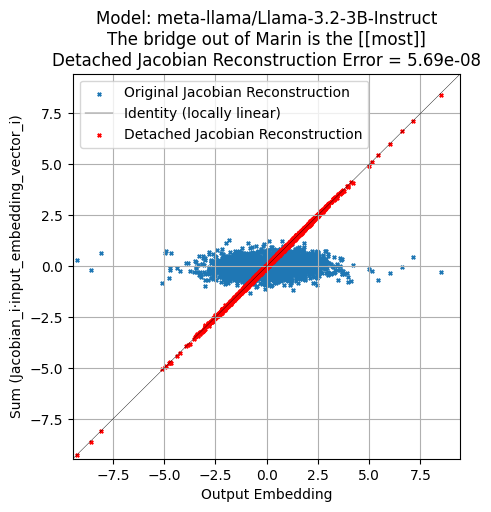

Computing col norms for token position 0
Computing col norms for token position 1
Computing col norms for token position 2
Computing col norms for token position 3
Computing col norms for token position 4
Computing col norms for token position 5
Computing col norms for token position 6
Computing col norms for token position 7
Mode: row_col_vectors


/content/llms-are-llms/src/JacobianAnalyzer.py:1474: UserWarning: Glyph 21482 (\N{CJK UNIFIED IDEOGRAPH-53EA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/content/llms-are-llms/src/JacobianAnalyzer.py:1478: UserWarning: Glyph 21482 (\N{CJK UNIFIED IDEOGRAPH-53EA}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{filename_png}.png', dpi=300, bbox_inches='tight')
/content/llms-are-llms/src/JacobianAnalyzer.py:1481: UserWarning: Glyph 21482 (\N{CJK UNIFIED IDEOGRAPH-53EA}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{filename}.pdf", bbox_inches='tight')
/content/llms-are-llms/src/JacobianAnalyzer.py:1481: UserWarning: Glyph 21482 (\N{CJK UNIFIED IDEOGRAPH-53EA}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{filename}.pdf", bbox_inches='tight')
/content/llms-are-llms/src/JacobianAnalyzer.py:1482: UserWarning: Glyph 21482 (\N{CJK UNIFIED IDEOGRAPH-53EA}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{filename}.svg", bbox_inches='tight')
/usr/local/lib/python3.11

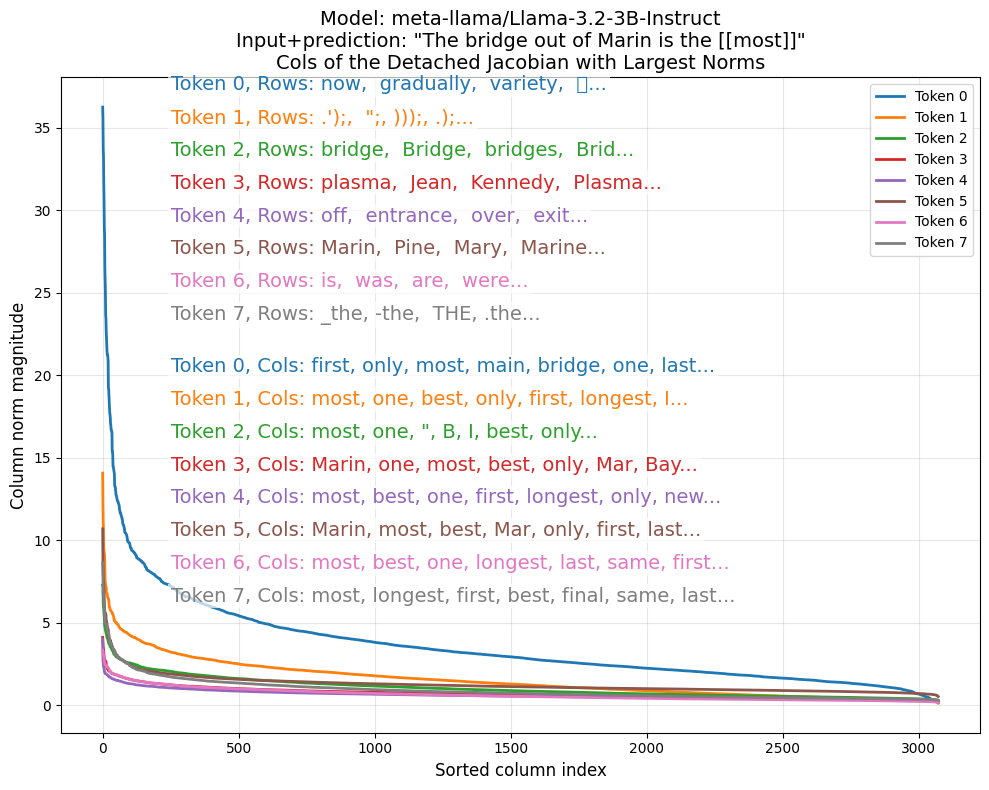

Computing SVD for token position 0
Computing SVD for token position 1
Computing SVD for token position 2
Computing SVD for token position 3
Computing SVD for token position 4
Computing SVD for token position 5
Computing SVD for token position 6
Computing SVD for token position 7
Token 0, U 0, mag=233.91:    most  best  one  I  "  only  Mar
Token 1, U 0, mag=107.41:    most  one  best  I  B  only  first
Token 2, U 0, mag=64.35:    most  one  "  only  B  I  best
Token 3, U 0, mag=37.46:    most  one  Marin  best  only  Mar  "
Token 4, U 0, mag=30.49:    most  Marin  one  best  only  Mar  last
Token 5, U 0, mag=56.06:  Marin  most    Bay  best  only  one  Mar
Token 6, U 0, mag=38.16:    most  one  best  first  same  last  longest
Token 7, U 0, mag=57.82:  most    longest  first  one  final  last  same
Mode: singular_vectors


/content/llms-are-llms/src/JacobianAnalyzer.py:1474: UserWarning: Glyph 21482 (\N{CJK UNIFIED IDEOGRAPH-53EA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/content/llms-are-llms/src/JacobianAnalyzer.py:1474: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/content/llms-are-llms/src/JacobianAnalyzer.py:1478: UserWarning: Glyph 21482 (\N{CJK UNIFIED IDEOGRAPH-53EA}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{filename_png}.png', dpi=300, bbox_inches='tight')
/content/llms-are-llms/src/JacobianAnalyzer.py:1478: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig(f'{filename_png}.png', dpi=300, bbox_inches='tight')
/content/llms-are-llms/src/JacobianAnalyzer.py:1481: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig(f"{filename}.pdf", bbox_inches='tight')
/content/llms-are-llms/src/JacobianAnalyzer.py:1481: UserWarning: Glyph 21482 (\N{CJK UNIFIED IDEOGRAPH-53EA}) missing from font(s) DejaVu Sans.

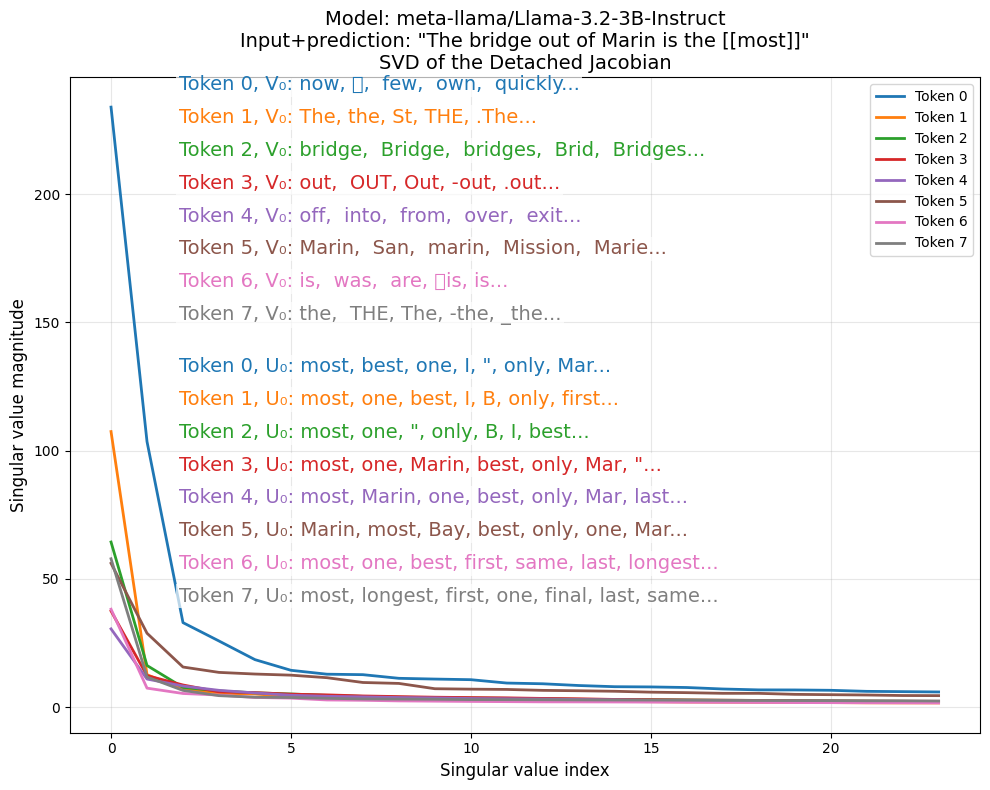

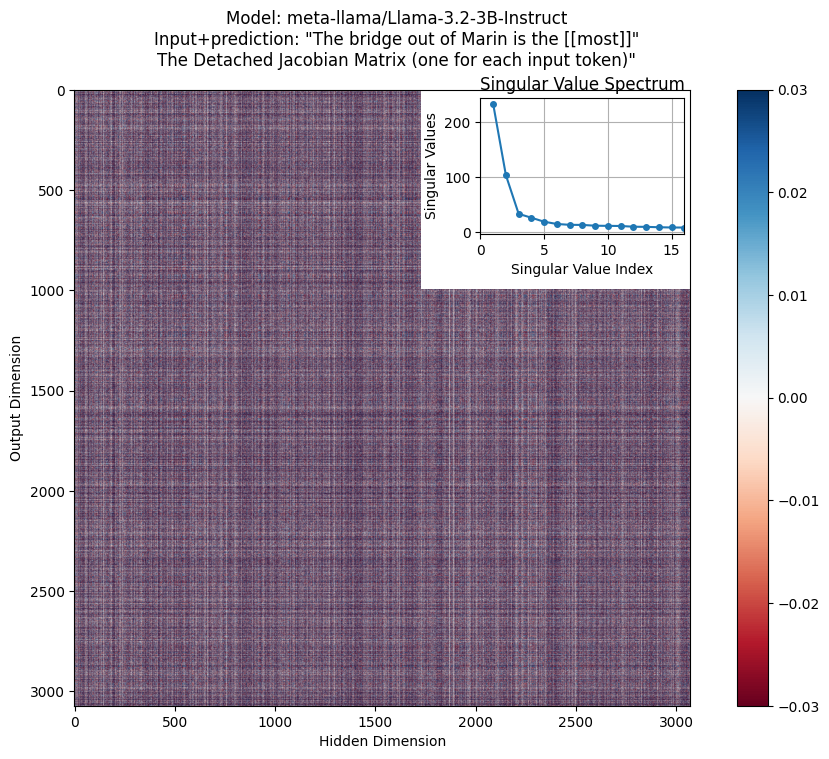

<Figure size 640x480 with 0 Axes>

In [1]:
import os
from google.colab import userdata

# Set environment variables
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = '1'
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

# Execute commands - os.system shows output in real-time by default
os.system('git clone https://github.com/jamesgolden1/llms-are-llms.git')
os.chdir('llms-are-llms')
os.system('pip install -r requirements.txt --no-deps')
# os.system(f'python -u run_detached_jacobian.py --hf_token {os.environ["HF_TOKEN"]} --model_name "gemma-3-4b" --text "The lightning"')

text_input = "The bridge out of Marin is the"
model_name = "llama-3.2-2B"
hf_token = os.environ["HF_TOKEN"]

%run run_detached_jacobian.py --text "{text_input}" --hf_token "{hf_token}" --model_name "{model_name}" --dtype "float64"
